![](https://target.scene7.com/is/image/Target/GUEST_ae1dac87-cc0b-4758-8f6a-b2d864260eda?wid=488&hei=488&fmt=pjpeg) 
![](https://upload.wikimedia.org/wikipedia/en/3/37/Jumpman_logo.svg)

In [1]:
# Import packages
import pandas as pd
import numpy as np
from sklearn import linear_model
import requests
# from nba_api.stats import endpoints
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup

In [2]:
import scipy
import emcee
import numba
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from corner import corner 
from termcolor import colored

sns.set()
current_palette = sns.color_palette()

/Users/amitklinger/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Table of Contents:
    1.Problem Statement
    2. Data Exploration for single year
    3. Positional-PER (pPER): New approach for selecting MVP
     3.1. Naive pPER exploration
    4. Finding model parameters
     4.1. LR Model for mean PER vs. Year
        4.1.1. Naive approach
        4.1.2. Advanced approach: Per position mean PER
     4.2. pPER for all years
     4.1. Bayesian Inference single parameter: Uniform prior
     4.2. Bayesian Inference single parameter: Normal prior
     4.3. Bayesian Inference two parameters: Uniform prior
     4.4. Bayesian Inference two parameters: Normal prior
     4.5. MCMC 3d
     4.6. Scipy optimization using fmin
     4.7. ABC
    5. Model Evalution of Adjusted PER
         5.1. Single year (2017) evalution
         5.2. Comparison of MVP vs. aMVP 
    6. Conclusions
    
***
***

## Problem Statement: **Who is the NBA MVP ???**

This is one of the most debatable questions that rises each year... 

The [Most Valuable Player (MVP)](https://en.wikipedia.org/wiki/NBA_Most_Valuable_Player_Award) award is decided by a panel of sportswriters and broadcasters throughout the United States and Canada. The player with the highest point total wins the award.

This selection might be biased as emotions might effect the sportwriters' decision instead of analytic facts and measureable statistics.

In this work, we would like to propuse new inovative method for selecting the MVP.

***

Currently the main single statistics that sportswriters and broadcasters is PER.

The [player efficiency rating (PER)](https://en.wikipedia.org/wiki/Player_efficiency_rating). is John Hollinger's all-in-one basketball rating, which attempts to boil down all of a player's contributions into one number.

The PER formula is the following:

![](https://squared2020.files.wordpress.com/2017/09/screen-shot-2017-09-01-at-8-17-08-pm.png) $\quad (1)$
![](https://squared2020.files.wordpress.com/2017/09/screen-shot-2017-09-01-at-11-22-07-am.png) $\quad (2)$

Finally we get:

![](https://squared2020.files.wordpress.com/2017/09/screen-shot-2017-09-01-at-11-24-24-am.png) $\quad (3)$

We would not get into the entire mathematical calculation and different adjusted that were made throughout the years.

This PER metric has some drawbacks, the main one would be that it does not take into account the position of the player on the floor.

We would like to suggest another adjustement on the PER metric to solve that, we call that Positional-PER (pPER).

This metric would help to distinct a dominance of a player with regards to his position on the floor, compared to fellow players on the same position.

This metric, we believe, indicates best the player that shall be elected to be the Most Valuable Player.

In addition, the pPER can help college scouts to select draftees in the upcoming NBA draft as most teams seek a specific position in a given year. For example, in 1984 the Huston Rockets selected first Hakeem Olajuwon as they needed a Center (the best player from this draft is of course the SG Michael Jordan)

**pPER formula:**

$$
pPER = \frac{PER - \mu}{\sigma}  \quad (4)
$$

where:

$\mu$ is the PER mean w.r.t. the player's position

$\sigma$ is the PER standard deviation w.r.t the player's position

We will build a model which estimates the model parameters, i.e. $\Theta=(\hat{\mu} , \hat{\sigma})$ for each position and adjust the PER accordingly to calculate pPER and select the adjusted-MVP (aMVP) in our opinion

In [3]:
mvp_dict = {2019: 'Giannis Antetokounmpo',2018: 'James Harden',2017: 'Russell Westbrook',2016: 'Stephen Curry',2015: 'Stephen Curry',2014: 'Kevin Durant',2013: 'LeBron James',2012: 'LeBron James',2011: 'Derrick Rose',2010: 'LeBron James',2009: 'LeBron James',2008: 'Kobe Bryant',2007: 'Dirk Nowitzki',2006: 'Steve Nash',2005: 'Steve Nash',2004: 'Kevin Garnett',2003: 'Tim Duncan',2002: 'Tim Duncan',2001: 'Allen Iverson',1900: "Shaquille O'Neal",1999: 'Karl Malone',1998: 'Michael Jordan',1997: 'Karl Malone',1996: 'Michael Jordan',1995: 'David Robinson',1994: 'Hakeem Olajuwon',1993: 'Charles Barkley',1992: 'Michael Jordan',1991: 'Michael Jordan',1990: 'Magic Johnson',1989: 'Magic Johnson',1988: 'Michael Jordan',1987: 'Magic Johnson',1986: 'Larry Bird',1985: 'Larry Bird',1984: 'Larry Bird',1983: 'Moses Malone',1982: 'Moses Malone',1981: 'Julius Erving',1980: 'Kareem Abdul-Jabbar',1979: 'Moses Malone',1978: 'Bill Walton',1977: 'Kareem Abdul-Jabbar',1976: 'Kareem Abdul-Jabbar',1975: 'Bob McAdoo',1974: 'Kareem Abdul-Jabbar',1973: 'Dave Cowens',1972: 'Kareem Abdul-Jabbar',1971: 'Kareem Abdul-Jabbar',1970: 'Willis Reed',1969: 'Wes Unseld',1968: 'Wilt Chamberlain',1967: 'Wilt Chamberlain',1966: 'Wilt Chamberlain',1965: 'Bill Russell',1964: 'Oscar Robertson',1963: 'Bill Russell',1962: 'Bill Russell',1961: 'Bill Russell',1960: 'Wilt Chamberlain',1959: 'Bob Pettit',1958: 'Bill Russell',1957: 'Bob Cousy',1956: 'Bob Pettit'}


In [4]:
class nbaDataFetch(object):
    def __init__(self):
        self.min_games = 20
        self.mvps_dict = mvp_dict
        
    def get_url(self, stats='basic', year=None):
        # 'basic' / 'advanced' (with PER)
        if stats is 'basic':
            url = 'https://www.basketball-reference.com/leagues/NBA_{}_per_game.html'.format(year)
        elif stats is 'advanced':
            url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'.format(year) # advanced statistics - with PER
        else:
            print("Unknown stats mode: Please choose 'basic' / 'advanced'")
        print('fetching url:\n{}'.format(url))
        return url
    
    def convert_df_to_numeric(self, df, columns_to_convert_to_numeric):
        for col in columns_to_convert_to_numeric:
            df[col] = pd.to_numeric(df[col])
        return df
    
    def preprocess_df(self, original_df, columns_to_convert_to_numeric):
        df = original_df.copy()
        df['Player'] = df['Player'].str.replace('*', '')
        if '\xa0' in df.columns: # Empty column
            df.drop(columns=['\xa0'], inplace=True)
        df.replace('', np.nan, inplace=True) # convert '' to nan in order to use dropna
        df.dropna(inplace=True)  # Remove players with empty stats (didn't play enough)

        # Remove Players with multiple positions (only 4 such players)
        df['Pos'] = df['Pos'].apply(lambda x: x.split('-')[0] if '-' in x else x)

        df = self.convert_df_to_numeric(df, columns_to_convert_to_numeric)
        # Remove players with less than min_games
        df.drop(df[df.G < self.min_games].index, inplace=True)
        return df
    
    def full_data_fetching(self, url):
        r = requests.get(url)
        r_html = r.text
        soup = BeautifulSoup(r_html,'html.parser')

        table = soup.find_all(class_="full_table")

        # Extracting List of column names
        head = soup.find(class_="thead")
        column_names_raw = [head.text for item in head][0]
        column_names_polished = column_names_raw.replace("\n",",").split(",")[2:-1]

        # Extracting full list of player_data
        players=[]
        for i in range(len(table)):
            player_=[]
            for td in table[i].find_all("td"):
                player_.append(td.text)
            players.append(player_)
        df = pd.DataFrame(players, columns=column_names_polished)
        return df
    
    def create_database(self, years):
        columns_to_convert = ['G','PER'] # ['Age','G','MP','PER']
        wanted_columns = ['Player','Pos','PER']
        db = pd.DataFrame()

        for y in range(*years,1):
            url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'.format(y)
            df_tmp = self.full_data_fetching(url)
            df_tmp = self.preprocess_df(df_tmp, columns_to_convert)
            df_tmp = df_tmp[wanted_columns]
            df_tmp['Year'] = y
            df_tmp['MVP'] = False
            df_tmp.loc[df_tmp['Player'] == self.mvps_dict[y], 'MVP'] = True # Add MVP boolean column to db
            db = db.append(df_tmp, ignore_index=True)

        return db


***
***
## Data Exploration for a single year

In [5]:
data_fetcher = nbaDataFetch()

In [6]:
year = 2017
columns_to_convert_to_numeric = ['Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS' ,'DWS','WS','WS/48','OBPM','DBPM','BPM','VORP']
url2fetch = data_fetcher.get_url(stats='advanced', year=year)
df = data_fetcher.full_data_fetching(url2fetch)
df = data_fetcher.preprocess_df(df, columns_to_convert_to_numeric)
unique_pos = np.unique(df['Pos'])


fetching url:
https://www.basketball-reference.com/leagues/NBA_2017_advanced.html


In [7]:
df.head()

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Álex Abrines,SG,23,OKC,68,1055,10.1,0.560,0.724,0.144,...,8.3,15.9,1.2,0.9,2.1,0.096,-1.3,-0.4,-1.6,0.1
1,Quincy Acy,PF,26,TOT,38,558,11.8,0.565,0.529,0.353,...,9.7,16.8,0.5,0.5,0.9,0.082,-1.5,-0.6,-2.1,0.0
2,Steven Adams,C,23,OKC,80,2389,16.5,0.589,0.002,0.392,...,16.0,16.2,3.3,3.1,6.5,0.130,-0.2,0.0,-0.2,1.1
3,Arron Afflalo,SG,31,SAC,61,1580,8.9,0.559,0.360,0.221,...,8.4,14.4,1.2,0.2,1.4,0.043,-2.1,-1.5,-3.6,-0.7
4,Alexis Ajinça,C,28,NOP,39,584,12.9,0.529,0.022,0.225,...,13.7,17.2,0.0,0.9,1.0,0.080,-4.0,0.7,-3.3,-0.2


In [8]:
df.describe()

,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
count,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,...,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000
mean,26.532688,61.641646,1422.503632,13.745763,0.541133,0.315169,0.260843,4.806538,15.165617,9.984988,...,12.638015,18.780145,1.576755,1.447458,3.022760,0.088683,-0.800242,-0.027603,-0.832930,0.738015
std,4.299698,17.543909,753.730124,4.829346,0.054131,0.203826,0.127287,3.822364,6.120079,4.644677,...,4.031055,5.262806,2.170308,1.052240,2.924954,0.059714,2.571025,1.118474,2.887457,1.485376
min,19.000000,20.000000,93.000000,0.100000,0.285000,0.000000,0.000000,0.000000,2.900000,2.400000,...,2.200000,8.800000,-1.700000,0.000000,-0.800000,-0.168000,-8.800000,-3.500000,-11.700000,-1.400000
25%,23.000000,50.000000,788.000000,10.400000,0.509000,0.160000,0.173000,1.900000,10.400000,6.300000,...,9.800000,14.800000,0.100000,0.600000,0.900000,0.051000,-2.400000,-0.800000,-2.500000,-0.100000
50%,26.000000,67.000000,1406.000000,13.100000,0.542000,0.330000,0.238000,3.200000,13.900000,8.700000,...,12.500000,18.200000,0.900000,1.200000,2.300000,0.085000,-1.000000,-0.100000,-1.100000,0.300000
75%,29.000000,76.000000,2054.000000,16.300000,0.576000,0.457000,0.334000,7.000000,19.000000,12.800000,...,15.100000,21.600000,2.300000,2.100000,4.100000,0.119000,0.500000,0.700000,0.500000,1.000000
max,40.000000,82.000000,3048.000000,30.600000,0.703000,0.870000,0.762000,17.100000,36.200000,25.200000,...,35.200000,41.700000,11.500000,6.000000,15.000000,0.280000,8.700000,3.900000,11.100000,9.300000


Now let's take a look at the PER accross $\bf{all}$ players in during this season

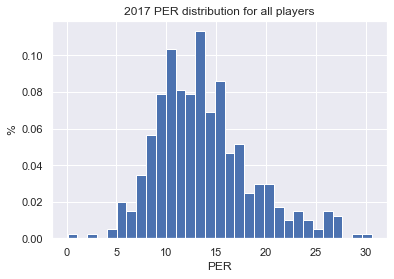

In [9]:
plt.hist(df['PER'], bins=31, density=True)
plt.xlabel('PER')
plt.ylabel('%')
plt.title(f'{year} PER distribution for all players')
plt.show()

In [10]:
max_per = df[df['PER'] == df['PER'].max()].squeeze()
print('Player with maximum PER for year {} is {} with PER of {}'.format(year, max_per['Player'], max_per['PER']))
print('MVP for year {} is {}'.format(year, mvp_dict[year]))

Player with maximum PER for year 2017 is Russell Westbrook with PER of 30.6
MVP for year 2017 is Russell Westbrook


This suggests that indeed the MVP should be chosen according to maximum PER, *is that really the case?*
***

Now we will split the data to positions to see if there is any difference

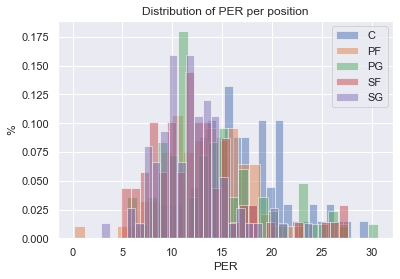

In [11]:
for i, p in enumerate(unique_pos):
    plt.hist(df[df['Pos']==p]['PER'], alpha=0.5, label=p, bins=25, density=True, color=current_palette[i])
plt.xlabel('PER')
plt.ylabel('%')
plt.title('Distribution of PER per position')
plt.legend()
plt.show()

Assuming Normal distribution - Let's find the $\Theta=(\mu , \sigma)$ parameters for each position

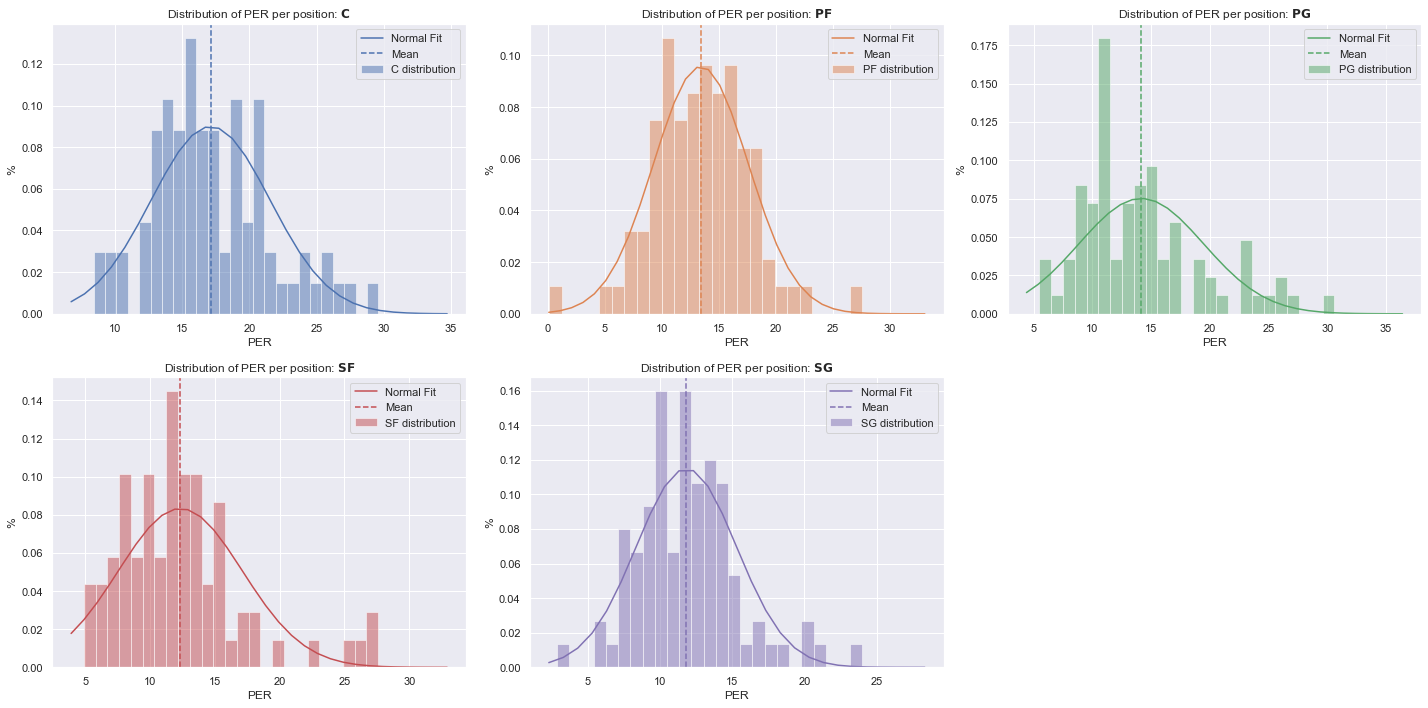

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i,p in enumerate(unique_pos):
    d = df[df['Pos']==p]['PER']
    x_axis = np.arange(np.min(d)*0.8, np.max(d)*1.2, 1)
    ax = axes[i//3][i%3]
    ax.plot(x_axis, scipy.stats.norm.pdf(x_axis,np.mean(d),np.std(d)), color=current_palette[i], label='Normal Fit')
    ax.hist(d, alpha=0.5, label=f'{p} distribution', bins=25, density=True, color=current_palette[i])
    ax.axvline(d.mean(), linestyle='--', color=current_palette[i], label='Mean')
    ax.legend()
    ax.set_xlabel('PER')
    ax.set_ylabel('%')
    ax.set_title(f'Distribution of PER per position: ' + r"$\bf{" + p + "}$")
    
axes[-1, -1].axis('off')
fig.tight_layout()
plt.show()


We can see from the plots above that the PER has different statistics accross positions!
***
***

### Positional-PER (pPER): New approach for selecting MVP
Let's investigate our new metric (pPER) and compare to the PER

In [13]:
def std_dist(per, mean_per, std_per):
    return (per-mean_per)/std_per

def add_pPER_2_db(db, year, pos, μ=None, σ=None):
    df1 = db.loc[(db['Year'] == year) & (db['Pos'] == pos)].copy()
    if μ==None: μ = df1['PER'].mean()
    if σ==None: σ = df1['PER'].std()
    df1.loc[:, 'pPER'] = round(std_dist(df1['PER'], μ, σ),2)
    db.loc[df1.index, 'pPER'] = df1['pPER']
    return 

def get_max_stat(df, stat):
    max_stat = df.loc[df[stat] == df[stat].max(), ['Player','PER','pPER']].squeeze()
    return max_stat


#### Naive pPER exploration

In [14]:

dbb = data_fetcher.create_database((year, year+1))
print (f"\033[4mYear: {year}\033[0m")
max_per_pos_dict = {}
for i, p in enumerate(unique_pos):
    pos_df = dbb.loc[dbb['Pos'] == p].copy()
    max_per_s = pos_df.loc[pos_df['PER'] == pos_df['PER'].max(), ['Player','PER']].squeeze()
    pPER = std_dist(max_per_s['PER'], np.mean(pos_df['PER']), np.std(pos_df['PER']))
    print (f'For position {p}:')
    print (f"Player with maximum PER within position is {max_per_s['Player']} with PER = {max_per_s['PER']}")
    print (f'With pPER of \033[1m{pPER:.2f}σ\033[0m')
    max_per_pos_dict[p] = {'Player' : max_per_s['Player'], 'PER' : max_per_s['PER'], 'pPER' : pPER}


Year: 2017
For position C:
Player with maximum PER within position is Boban Marjanović with PER = 29.6
With pPER of 2.82σ
For position PF:
Player with maximum PER within position is Kevin Durant with PER = 27.6
With pPER of 3.40σ
For position PG:
Player with maximum PER within position is Russell Westbrook with PER = 30.6
With pPER of 3.10σ
For position SF:
Player with maximum PER within position is Kawhi Leonard with PER = 27.6
With pPER of 3.19σ
For position SG:
Player with maximum PER within position is DeMar DeRozan with PER = 24.0
With pPER of 3.50σ


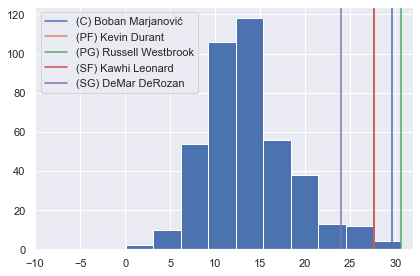

In [15]:
plt.hist(dbb['PER'])
for i,(k,v) in enumerate(max_per_pos_dict.items()):
    plt.axvline(v['PER'], color=current_palette[i], label=f"({k}) {v['Player']}")
plt.xlim(-10,32)
plt.tight_layout()
plt.legend()
plt.show()

WOW ! This is incredicble... Altough DeMar Derozan has the absolute lowest PER when comparing the maximum PER of each position, we can see that he is an exeptional player with respect to his position ($3.5\sigma$)! 

This is pretty innovative!

We can see that in 2017 the Positional PER statistics would have chosen a different MVP (DeMar Derozan instead of Russel Westbrook) and therefore it might be the correct statistics to look at when choosing MVP
***
***
Now, we'll create several models to estimate $\Theta=({\hat{\mu}} , {\hat{\sigma}})$ parameters for each position

## Finding model parameters
### LR Model for estimating the mean PER vs. Year

Let's see if the PER per position has changed thoughout the years.
We'll do that using Linear Regression, where the null hypothesis is that $\alpha$ = 0, i.e. it has not changed.

In [16]:
years_range = (2013,2020)
dbb = data_fetcher.create_database(years_range)

In [17]:
print(dbb[dbb['MVP']])
dbb.head()

                     Player Pos   PER  Year   MVP
186            LeBron James  PF  31.6  2013  True
524            Kevin Durant  SF  29.8  2014  True
913           Stephen Curry  PG  28.0  2015  True
1333          Stephen Curry  PG  31.5  2016  True
2048      Russell Westbrook  PG  30.6  2017  True
2225           James Harden  SG  29.8  2018  True
2497  Giannis Antetokounmpo  PF  30.9  2019  True


,Player,Pos,PER,Year,MVP
0,Quincy Acy,PF,15.9,2013,False
1,Jeff Adrien,PF,13.4,2013,False
2,Arron Afflalo,SF,13.0,2013,False
3,Cole Aldrich,C,11.1,2013,False
4,LaMarcus Aldridge,PF,20.4,2013,False


### Naive approach (Without dividing into positions)

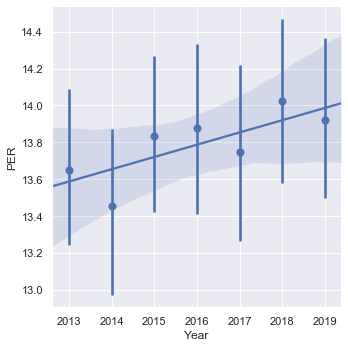

In [18]:
sns.lmplot(
    x='Year', 
    y='PER', 
    data=dbb, 
    x_estimator=np.mean
);

In [19]:
res = scipy.stats.linregress(dbb['Year'], dbb['PER'])
print('slope = {:.3f}, intercept = {:.3f}, P-value = {:.3f}'.format(res.slope, res.intercept, res.pvalue))


slope = 0.066, intercept = -120.182, P-value = 0.121


The P-value gives the probability to get this data if the null hypothesis is correct. In this case, the null hypothesis is $slope=0$.
From the entire data together we could not really conclude anything, let's try to differentiate according to position on the floor

### Advanced approach: Per position mean PER

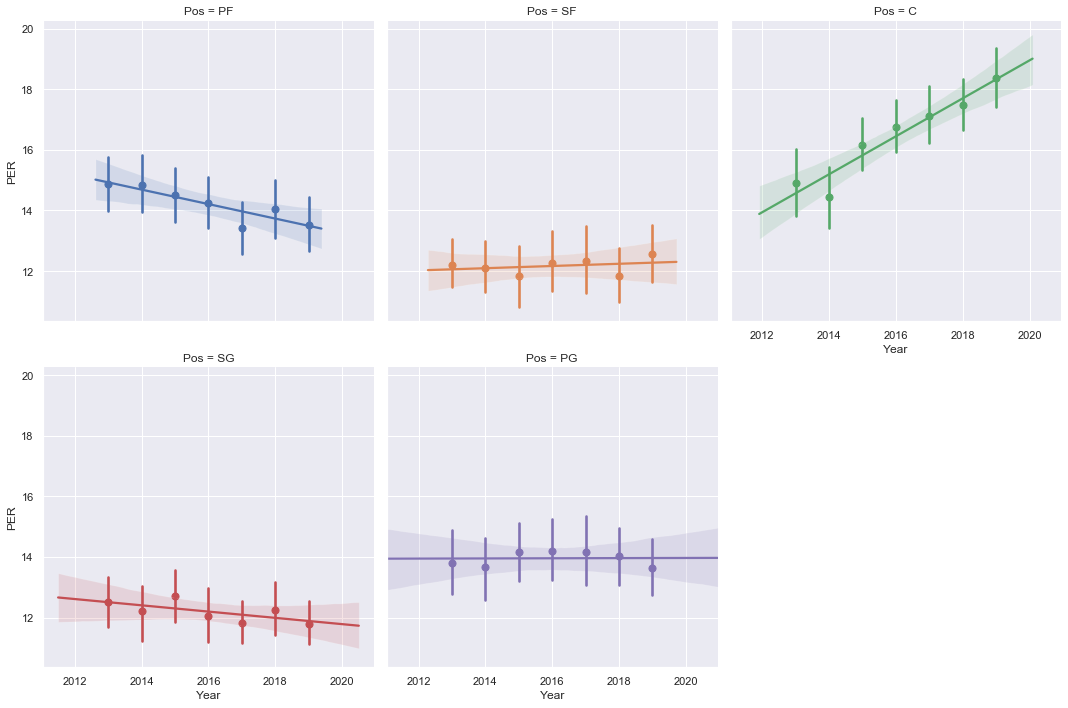

In [20]:
sns.lmplot(
    x='Year', 
    y='PER', 
    data=dbb, 
    x_estimator=np.mean,
    hue='Pos',
    col='Pos', 
    col_wrap=3, 
#     ci=None,
    sharex=True, 
    sharey=True
);

In [21]:
LR_pos_list = []
for i, pos in enumerate(unique_pos):
    print (f"\033[4mPosition: {pos}\033[0m")
    pos_df = dbb[dbb['Pos']==pos]
    res_pos = scipy.stats.linregress(pos_df['Year'], pos_df['PER'])
    LR_pos_list.append({'Pos':pos,'slope':res_pos.slope,'intercept':res_pos.intercept,}) #'LR-mean':res_pos.slope * np.unique(pos_df['Year']) + res_pos.intercept})
    print('slope = {:.3f}, intercept = {:.3f}, P-value = {:.3f}'.format(res_pos.slope, res_pos.intercept, res_pos.pvalue))

LR_pos_df = pd.DataFrame(LR_pos_list)


Position: C
slope = 0.626, intercept = -1246.556, P-value = 0.000
Position: PF
slope = -0.239, intercept = 495.921, P-value = 0.007
Position: PG
slope = 0.002, intercept = 9.028, P-value = 0.980
Position: SF
slope = 0.036, intercept = -61.312, P-value = 0.694
Position: SG
slope = -0.104, intercept = 220.907, P-value = 0.192


In [22]:
print("These p-value results suggests that for 'C' position (Centers) the null hypothesis is incorrect (and perhaps also for 'PF' and 'SG'). We can see that in the past {} years the 'C' PER increases by {:.2f} per year, which is incredible!".format(len(range(*years_range)), LR_pos_df.loc[LR_pos_df['Pos']=='C','slope'].squeeze()))


These p-value results suggests that for 'C' position (Centers) the null hypothesis is incorrect (and perhaps also for 'PF' and 'SG'). We can see that in the past 7 years the 'C' PER increases by 0.63 per year, which is incredible!


Now, let's evalute who should be the aMVP (Adjusted MVP) when using the mean value as the Linear Regression mean-PER instead of the current year mean PER for each position.


In [23]:
LR_pos_df

,Pos,slope,intercept
0,C,0.626490,-1246.555623
1,PF,-0.238944,495.921482
2,PG,0.002446,9.027717
3,SF,0.036448,-61.312017
4,SG,-0.103527,220.907437


In [24]:
for pos in unique_pos:
    μ_lr = LR_pos_df.loc[LR_pos_df['Pos']==pos,'slope'].squeeze() * year + LR_pos_df.loc[LR_pos_df['Pos']==pos,'intercept'].squeeze()
    add_pPER_2_db(dbb, year, pos, μ_lr)
    df1 = dbb.loc[dbb['Pos'] == pos].copy()
#     aMVP_lr_PER = df1.loc[df1['pPER'] == df1['pPER'].max(),['Player', 'pPER']].squeeze()
#     print('The best {} when using Linear Regression for the mean-PER estimate is:\n{} with pPER = {:.2f}'.
#           format(pos, aMVP_lr_PER['Player'], aMVP_lr_PER['pPER']))

aMVP_lr_PER = dbb.loc[dbb['pPER'] == dbb['pPER'].max(),'Player'].squeeze()
print('The aMVP when using Linear Regression for the mean-PER estimate is:\n{} with pPER = {:.2f} as opposed to pPER of {:.2f} when using only {} mean'.format(aMVP_lr_PER, dbb['pPER'].max(),[v['pPER'] for k, v in max_per_pos_dict.items() if v['Player'] == aMVP_lr_PER][0],year))



The aMVP when using Linear Regression for the mean-PER estimate is:
DeMar DeRozan with pPER = 3.41 as opposed to pPER of 3.50 when using only 2017 mean


Using mean value from out linear regression model shows significant shift on all positions. **DeMar DeRozan's pPER decreased by almost 0.1$\sigma$ !**
***

After evaluting pPER for a single year, we need to calculate the pPER for every player for every year

In [25]:
# Notice that we return the measure the pPER with respect to the actual mean-PER in the current year,
# not the linear-regression mean-PER for that year
for yy in range(*years_range):
    for pos in unique_pos:
        add_pPER_2_db(dbb, yy, pos)

assert ~(dbb.isnull().values.any()), 'Not all pPER values were calculated'

In [26]:
dbb.describe()

,PER,Year,pPER
count,2909.000000,2909.000000,2909.000000
mean,13.787762,2016.012719,-0.000024
std,4.619925,1.998670,0.994170
min,-3.800000,2013.000000,-4.050000
25%,10.700000,2014.000000,-0.650000
50%,13.300000,2016.000000,-0.060000
75%,16.500000,2018.000000,0.550000
max,31.600000,2019.000000,4.460000


In [27]:
dbb.head()

,Player,Pos,PER,Year,MVP,pPER
0,Quincy Acy,PF,15.9,2013,False,0.24
1,Jeff Adrien,PF,13.4,2013,False,-0.34
2,Arron Afflalo,SF,13.0,2013,False,0.22
3,Cole Aldrich,C,11.1,2013,False,-0.80
4,LaMarcus Aldridge,PF,20.4,2013,False,1.28


# TODO: [AK] I think that years_range should be the same for all models, no?

In [28]:
years_range=(2005,2020)

In [29]:
db = data_fetcher.create_database(years_range)

In [30]:
db.head(5)

,Player,Pos,PER,Year,MVP
0,Shareef Abdur-Rahim,PF,18.7,2005,False
1,Malik Allen,PF,14.2,2005,False
2,Ray Allen,SG,20.9,2005,False
3,Tony Allen,SG,14.7,2005,False
4,Rafer Alston,PG,16.5,2005,False


Calulate the global mean and std

In [31]:
μ_global = db['PER'].mean()
σ_global = db['PER'].std()
print (f'Global PER (accross all years - all players):\nμ_global = {μ_global:.2f}\nσ_global = {σ_global:.2f}')

Global PER (accross all years - all players):
μ_global = 13.61
σ_global = 4.55


In [32]:
def calc_per_mean_per_pos(pos, db):
    return db[db['Pos']==pos]['PER'].mean()

In [33]:
def calc_per_std_per_pos(pos, db):
    return db[db['Pos']==pos]['PER'].std()

In [34]:
μ_years_range = {pos:calc_per_mean_per_pos(pos, db) for pos in unique_pos}
σ_years_range = {pos:calc_per_std_per_pos(pos, db) for pos in unique_pos}

In [43]:
μ_years_range, σ_years_range

({'C': 14.91324717285947,
  'PF': 14.158870967741908,
  'PG': 13.751983122362866,
  'SF': 12.583109919571054,
  'SG': 12.575688434303702},
 {'C': 4.842008538054332,
  'PF': 4.421358610284668,
  'PG': 4.448914026279721,
  'SF': 4.349604754264275,
  'SG': 4.192445283931065})

Example of Shooting-Gaurd ('SG') position in 2017 season:

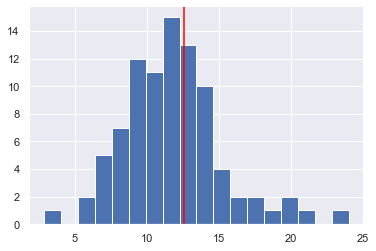

In [50]:
pos, year = 'SG', 2017
one_pos_one_year_d = db['PER'][(db['Pos']==pos) & (db['Year']==year)]
plt.hist(one_pos_one_year_d, bins=18)
plt.axvline(μ_years_range[pos], color='red')
sns.despine()
plt.show()

### Bayesian Inference Single Parameter Estimation: Uniform prior

Let's start with estimating the $\mu$ parameter while assuming $\sigma$ is constant

In [51]:
def log_likelihood(θ, X):
    μ, σ = θ
    return scipy.stats.norm(μ, σ).logpdf(X).sum()

In [52]:
def log_prior_2d_uni(μ):
    if μ > 0:
        return 0
    else:
        return -np.inf
    
def log_posterior_2d_uni(μ, X):
    pri = log_prior_2d_uni(μ)
    if np.isinf(pri): 
        return pri
    return pri + log_likelihood((μ, σ_global), X)

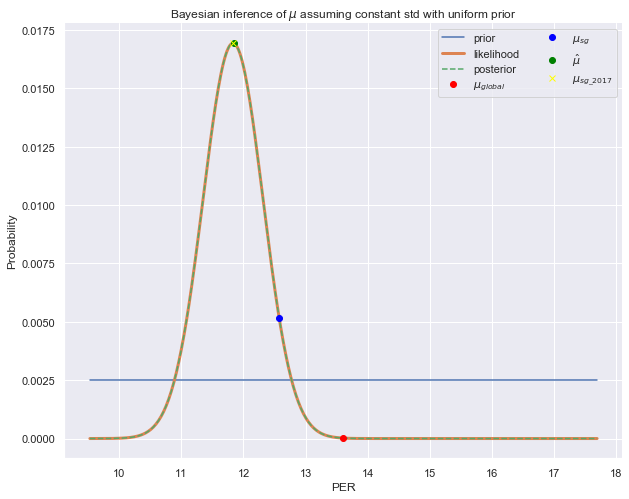

In [62]:
μ_range = np.linspace(μ_global*0.70, μ_global*1.3, 400)

pri = np.exp([log_prior_2d_uni(μ_) for μ_ in μ_range])
lik = np.exp([log_likelihood((μ_, σ_global), one_pos_one_year_d) for μ_ in μ_range])
post = np.exp([log_posterior_2d_uni(μ_, one_pos_one_year_d) for μ_ in μ_range])

μ_hat = μ_range[post.argmax()] # MAP

fig = plt.figure(figsize=((10,8)))
plt.plot(μ_range, pri/pri.sum(), label='prior')
plt.plot(μ_range, lik/lik.sum(), lw=3, label='likelihood')
plt.plot(μ_range, post/post.sum(), ls='--', label='posterior')

plt.plot(μ_global, np.exp(log_posterior_2d_uni(μ_global, one_pos_one_year_d))/post.sum(), 'o', color='red', label='$μ_{global}$')
plt.plot(μ_years_range[pos], np.exp(log_posterior_2d_uni(μ_years_range[pos], one_pos_one_year_d))/post.sum(), 'o', color='blue', label='$μ_{'+pos.lower()+'}$')
plt.plot(μ_hat, np.exp(log_posterior_2d_uni(μ_hat, one_pos_one_year_d))/post.sum(), 'o', color='green', label='$\hat{μ}$')
plt.plot(one_pos_one_year_d.mean(), np.exp(log_posterior_2d_uni(one_pos_one_year_d.mean(), one_pos_one_year_d))/post.sum(), 'x', color='yellow', label='$μ_{'+pos.lower()+'\_'+str(year)+'}$')

# X_σ = np.linspace(μ_hat-σ_global/10, μ_hat+σ_global/10)
# plt.fill_between(X_σ, np.exp(log_likelihood((μ_hat*0.9, σ_global), one_pos_one_year_d))/lik.sum(), 
#                  np.exp([log_likelihood((x, σ_global), one_pos_one_year_d) for x in X_σ])/lik.sum(), 
#                  alpha=0.5, label='$\pm 0.1*\sigma_{\hat{\mu}}$')

plt.xlabel("PER")
plt.ylabel("Probability")
plt.title(f'Bayesian inference of $\mu$ assuming constant std with uniform prior')
plt.legend(ncol=2)
sns.despine()

We can see that the $\mu_{global}$ which refers to the data accross all positions, all years is not aligned well with the posterior, but the mean value for the same position ('SG') across all years looks closer.

Of course, as the theory suggests, $\hat{\mu}$ and the mean value of the data, $\mu_{sg\_2017}$ , results with the same, and maximum postirior
***

### Bayesian Inference Single Parameter Estimation: Normal prior

Now let's find a better prior. Becasue we already saw that the data is distributed normaly, we can assume ~$N(\mu_{global},1)$

In [153]:
class BayesSingleParameterNormal():
    def __init__(self, df_1year_1pos, μ_global, σ_global, pos='SG', year=2017):
        self.df = df_1year_1pos
        self.μ_global = μ_global
        self.σ_global = σ_global
        self.pos = pos
        self.year = year
        pass
    
    def log_prior_2d_norm(self, μ):
        if μ > 0:
    #          b_prior = scipy.stats.truncnorm(-3, 3, loc=60, scale=20) TODO
            return scipy.stats.norm(self.μ_global, 1).logpdf(μ)
        else:
            return -np.inf

    def log_likelihood(self, θ, X):
        μ, σ = θ
        return scipy.stats.norm(μ, σ).logpdf(X).sum()

    def log_posterior_2d_norm(self, μ, X):
        pri = log_prior_2d_norm(μ)
        if np.isinf(pri): 
            return pri
        return pri + log_likelihood((μ, self.σ_global), X)

    def estimate_model_params(self):
        self.μ_range = np.linspace(self.μ_global*0.70, self.μ_global*1.3, 400)

        self.pri = np.exp([self.log_prior_2d_norm(μ_) for μ_ in μ_range])
        self.lik = np.exp([self.log_likelihood((μ_, self.σ_global), self.df) for μ_ in μ_range])
        self.post = np.exp([self.log_posterior_2d_norm(μ_, self.df) for μ_ in μ_range])

        self.μ_hat = μ_range[self.post.argmax()] # MAP
        return self.μ_hat

    def plot_results(self):
        fig = plt.figure(figsize=((10,8)))
        plt.plot(self.μ_range, self.pri/self.pri.sum(), label='prior')
        plt.plot(self.μ_range, self.lik/self.lik.sum(), lw=3, label='likelihood')
        plt.plot(self.μ_range, self.post/self.post.sum(), ls='--', label='posterior')

        plt.plot(self.μ_global, np.exp(self.log_posterior_2d_norm(self.μ_global, self.df))/self.post.sum(), 'o', color='red', label='$μ_{global}$')
        plt.plot(μ_years_range[self.pos], np.exp(self.log_posterior_2d_norm(μ_years_range[self.pos], self.df))/self.post.sum(), 'o', color='blue', label='$μ_{'+self.pos.lower()+'}$')
        plt.plot(self.μ_hat, np.exp(self.log_posterior_2d_norm(μ_hat, self.df))/self.post.sum(), 'o', color='green', label='$\hat{μ}$')
        plt.plot(self.df.mean(), np.exp(self.log_posterior_2d_norm(self.df.mean(), self.df))/post.sum(), 'x', color='yellow', label='$μ_{'+self.pos.lower()+'\_'+str(self.year)+'}$')

        plt.xlabel("PER")
        plt.ylabel("Probability")
        plt.title('Bayesian inference of $\mu$ assuming constant std with norm prior ~$N(\mu_{global},1)$')
        plt.legend(ncol=2)
        sns.despine()


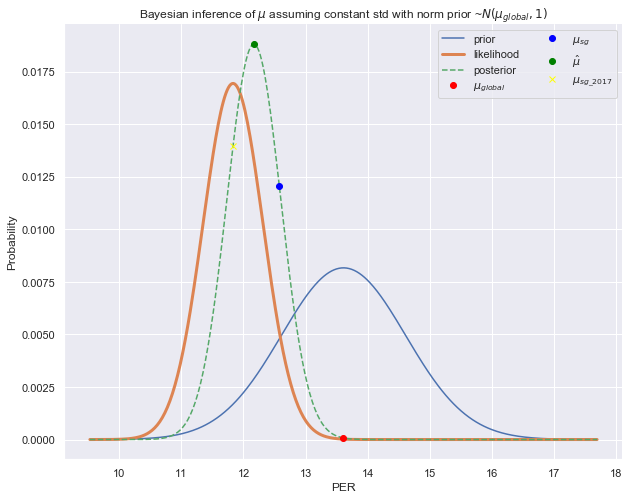

In [154]:
Bayes1Norm = BayesSingleParameterNormal(one_pos_one_year_d, μ_global, σ_global, pos, year)
Bayes1Norm_μ_hat = Bayes1Norm.estimate_model_params()
Bayes1Norm.plot_results()

# TODO: [AK] Below can be deleted as I inserted it into the class above and verified results (mu_hat) vs the below code

In [107]:
def log_prior_2d_norm(μ):
    if μ > 0:
#          b_prior = scipy.stats.truncnorm(-3, 3, loc=60, scale=20) TODO
        return scipy.stats.norm(μ_global, 1).logpdf(μ)
    else:
        return -np.inf
    
def log_posterior_2d_norm(μ, X):
    pri = log_prior_2d_norm(μ)
    if np.isinf(pri): 
        return pri
    return pri + log_likelihood((μ, σ_global), X)


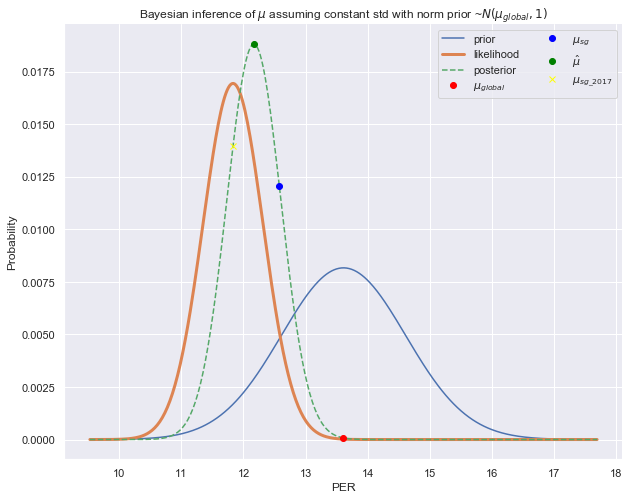

In [108]:
μ_range = np.linspace(μ_global*0.70, μ_global*1.3, 400)

pri = np.exp([log_prior_2d_norm(μ_) for μ_ in μ_range])
lik = np.exp([log_likelihood((μ_, σ_global), one_pos_one_year_d) for μ_ in μ_range])
post = np.exp([log_posterior_2d_norm(μ_, one_pos_one_year_d) for μ_ in μ_range])

μ_hat = μ_range[post.argmax()] # MAP

fig = plt.figure(figsize=((10,8)))
plt.plot(μ_range, pri/pri.sum(), label='prior')
plt.plot(μ_range, lik/lik.sum(), lw=3, label='likelihood')
plt.plot(μ_range, post/post.sum(), ls='--', label='posterior')

plt.plot(μ_global, np.exp(log_posterior_2d_norm(μ_global, one_pos_one_year_d))/post.sum(), 'o', color='red', label='$μ_{global}$')
plt.plot(μ_years_range[pos], np.exp(log_posterior_2d_norm(μ_years_range[pos], one_pos_one_year_d))/post.sum(), 'o', color='blue', label='$μ_{'+pos.lower()+'}$')
plt.plot(μ_hat, np.exp(log_posterior_2d_norm(μ_hat, one_pos_one_year_d))/post.sum(), 'o', color='green', label='$\hat{μ}$')
plt.plot(one_pos_one_year_d.mean(), np.exp(log_posterior_2d_norm(one_pos_one_year_d.mean(), one_pos_one_year_d))/post.sum(), 'x', color='yellow', label='$μ_{'+pos.lower()+'\_'+str(year)+'}$')

plt.xlabel("PER")
plt.ylabel("Probability")
plt.title('Bayesian inference of $\mu$ assuming constant std with norm prior ~$N(\mu_{global},1)$')
plt.legend(ncol=2)
sns.despine()

In [110]:
μ_global, σ_global, pos, year, μ_hat

(13.609763753510656, 4.547799177250915, 'SG', 2017, 12.16692413753697)

# TODO: [AK] Is next 3 cells duplication of the above?? for some reason the log_prior_2d_norm is a bit different

Now let's change the prior for our mean per position

In [57]:
def log_prior_2d_norm(μ):
    if μ > 0:
        return scipy.stats.norm(μ_years_range[pos], 1).logpdf(μ)
    else:
        return -np.inf
    
def log_posterior_2d_norm(μ, X):
    pri = log_prior_2d_norm(μ)
    if np.isinf(pri): 
        return pri
    return pri + log_likelihood((μ, σ_global), X)

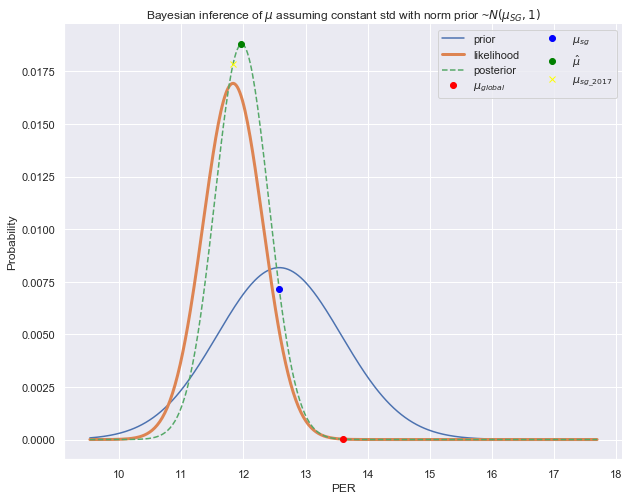

In [60]:
μ_range = np.linspace(μ_global*0.70, μ_global*1.3, 400)

pri = np.exp([log_prior_2d_norm(μ_) for μ_ in μ_range])
lik = np.exp([log_likelihood((μ_, σ_global), one_pos_one_year_d) for μ_ in μ_range])
post = np.exp([log_posterior_2d_norm(μ_, one_pos_one_year_d) for μ_ in μ_range])

μ_hat = μ_range[post.argmax()] # MAP

fig = plt.figure(figsize=((10,8)))
plt.plot(μ_range, pri/pri.sum(), label='prior')
plt.plot(μ_range, lik/lik.sum(), lw=3, label='likelihood')
plt.plot(μ_range, post/post.sum(), ls='--', label='posterior')

plt.plot(μ_global, np.exp(log_posterior_2d_norm(μ_global, one_pos_one_year_d))/post.sum(), 'o', color='red', label='$μ_{global}$')
plt.plot(μ_years_range[pos], np.exp(log_posterior_2d_norm(μ_years_range[pos], one_pos_one_year_d))/post.sum(), 'o', color='blue', label='$μ_{'+pos.lower()+'}$')
plt.plot(μ_hat, np.exp(log_posterior_2d_norm(μ_hat, one_pos_one_year_d))/post.sum(), 'o', color='green', label='$\hat{μ}$')
plt.plot(one_pos_one_year_d.mean(), np.exp(log_posterior_2d_norm(one_pos_one_year_d.mean(), one_pos_one_year_d))/post.sum(), 'x', color='yellow', label='$μ_{'+pos.lower()+'\_'+str(year)+'}$')

plt.xlabel("PER")
plt.ylabel("Probability")
plt.title(f'Bayesian inference of $\mu$ assuming constant std with norm prior ~$N(\mu_{{{pos}}},1)$')
plt.legend(ncol=2)
sns.despine()

The real data (yellow) fits better
***

### Bayesian Inference Two Parameters Estimation: Uniform prior

Now let's make it more complicated, we will try to estimate both the $\mu$ and the $\sigma$. Starting with uniform prior

In [65]:
# Becasue we will need to run these function accross all grid, we will C++ compile them
@numba.jit(forceobj=True)
def log_likelihood(θ, X):
    μ, σ = θ
    return scipy.stats.norm(μ, σ).logpdf(X).sum()

In [66]:
@numba.jit(forceobj=True)
def log_prior_3d_uni(θ):
    μ, σ = θ
    if μ > 0 and σ > 0:
        return 0
    else:
        return (-np.inf)
    
@numba.jit(forceobj=True)    
def log_posterior_3d_uni(θ, X):
    pri = log_prior_3d_uni(θ)
    if np.isinf(pri): 
        return pri
    return pri + log_likelihood(θ, X)

In [67]:
μ_range = np.linspace(μ_global*0.70, μ_global*1.3, 100)
σ_range = np.linspace(σ_global*0.60, σ_global*1.4, 100)

X, Y = np.meshgrid(μ_range, σ_range)

In [68]:
pri_grid_uni = np.empty([len(μ_range), len(σ_range)])
lik_grid_uni = np.empty([len(μ_range), len(σ_range)])
post_grid_uni = np.empty([len(μ_range), len(σ_range)])

for μi, μ_ in enumerate(μ_range):
    for σi, σ_ in enumerate(σ_range):
        pri_grid_uni[σi][μi] = np.exp(log_prior_3d_uni((μ_, σ_)))
        lik_grid_uni[σi][μi] = np.exp(log_likelihood((μ_, σ_), one_pos_one_year_d))
        post_grid_uni[σi][μi] = np.exp(log_posterior_3d_uni((μ_, σ_), one_pos_one_year_d))

In [69]:
σ_hat_idx, μ_hat_idx = np.unravel_index(post_grid_uni.argmax(), post_grid_uni.shape)
μ_hat, σ_hat = μ_range[μ_hat_idx], σ_range[σ_hat_idx]
μ_pos, σ_pos = one_pos_one_year_d.mean(), one_pos_one_year_d.std()

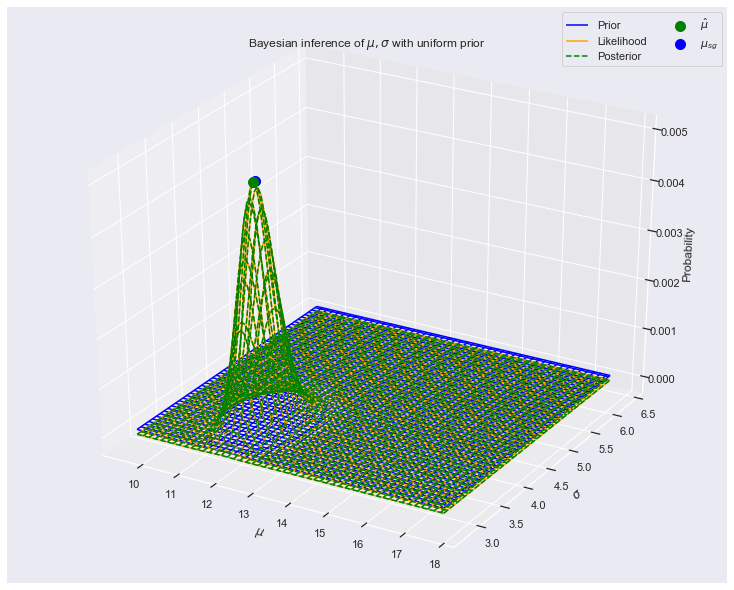

In [70]:
fig = plt.figure(figsize=((10,8)))
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, (pri_grid_uni/pri_grid_uni.sum()),  color='blue', label='Prior')
ax.plot_wireframe(X, Y, (lik_grid_uni/lik_grid_uni.sum()),  color='orange', label='Likelihood')
ax.plot_wireframe(X, Y, (post_grid_uni/post_grid_uni.sum()), color='green', linestyle='--', label='Posterior')

ax.scatter([μ_hat], [σ_hat], [np.exp(log_posterior_3d_uni((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_uni.sum()], s=100, color='green', label='$\hat{μ}$')
ax.scatter([μ_pos], [σ_pos], [np.exp(log_posterior_3d_uni((μ_pos, σ_pos), one_pos_one_year_d))/post_grid_uni.sum()], s=100, color='blue', label='$μ_{'+pos.lower()+'}$')

ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('Probability')
ax.set_title(f'Bayesian inference of $\mu,\sigma$ with uniform prior')

ax.legend(ncol=2)

plt.show()

In [71]:
print (f'μ_hat x σ_hat cordinates = ({μ_hat:.4f}, {σ_hat:.4f}, {np.exp(log_posterior_3d_uni((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_uni.sum():.6f})')
print (f'μ_pos x σ_pos coordinates = ({μ_pos:.4f}, {σ_pos:.4f}, {np.exp(log_posterior_3d_uni((μ_pos, σ_pos), one_pos_one_year_d))/post_grid_uni.sum():.6f})')


μ_hat x σ_hat cordinates = (11.8364, 3.4637, 0.004907)
μ_pos x σ_pos coordinates = (11.8315, 3.4933, 0.004897)


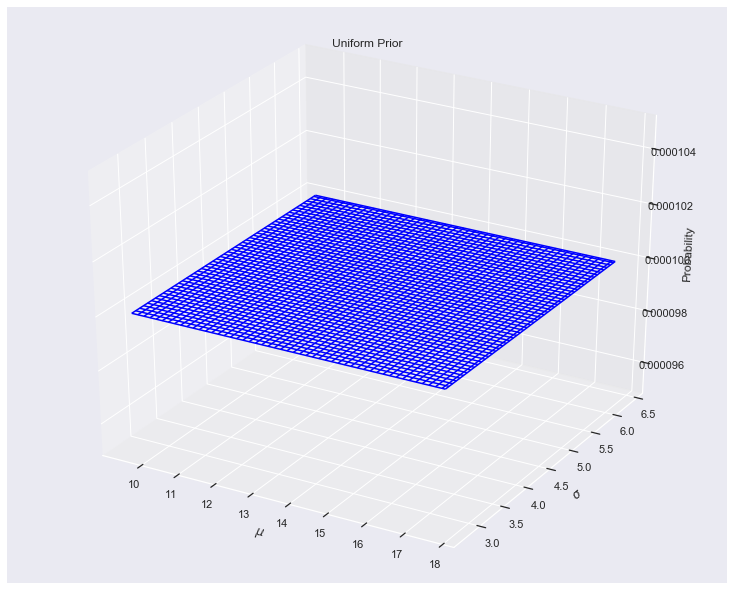

In [72]:
fig = plt.figure(figsize=((10,8)))
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, (pri_grid_uni/pri_grid_uni.sum()),  color='blue', label='Prior')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('Probability')
ax.set_title('Uniform Prior')
plt.show()

***
### Bayesian Inference Two Parameters Estimation: Normal prior

$\mu$ position looks very close to the max likelihood which is close to the maximum posterior. Let's take it one more step with normal prior $\mu$ ~ $N(\mu_{global},1)$ and  $\sigma$ ~ $N(\sigma_{global}, 1)$. 

That will give us better estimation in order to perform pPER calculations

In [73]:
μ_σ_cov = np.cov([db['PER'][db['Year']==y].mean() for y in range(*years_range)], [db['PER'][db['Year']==y].std() for y in range(*years_range)])[1][1]


Because there $\mu$ and $\sigma$ are dependant ($cov(\mu,\sigma)\neq0$) we will use multivariate distribution.
Create a covariance matrix with VAR=1 for both $\mu$ and $\sigma$ with calculated covariance

In [74]:
cov_mtrx=np.array([[1,μ_σ_cov], [μ_σ_cov, 1]])
cov_mtrx

array([[1.        , 0.02455787],
       [0.02455787, 1.        ]])

In [75]:
#TODO covarience

@numba.jit(forceobj=True)
def log_prior_3d_norm(θ):
    μ, σ = θ
    if μ > 0 and σ > 0:
        #return scipy.stats.norm(μ_years_range[pos], 1).logpdf(μ) + scipy.stats.norm(σ_years_range[pos], 1).logpdf(σ)
#         return scipy.stats.norm(μ_global, 1).logpdf(μ) + scipy.stats.norm(σ_global, 1).logpdf(σ)
        return scipy.stats.multivariate_normal([μ_global, σ_global], cov_mtrx).logpdf([μ, σ])
    else:
        return -np.inf

@numba.jit(forceobj=True)
def log_posterior_3d_norm(θ, X):
    pri = log_prior_3d_norm(θ)
    if np.isinf(pri): 
        return pri
    return pri + log_likelihood(θ, X)

In [76]:
pri_grid_norm = np.empty([len(μ_range), len(σ_range)])
lik_grid_norm = np.empty([len(μ_range), len(σ_range)])
post_grid_norm = np.empty([len(μ_range), len(σ_range)])

for μi, μ_ in enumerate(μ_range):
    for σi, σ_ in enumerate(σ_range):
        pri_grid_norm[σi][μi] = np.exp(log_prior_3d_norm((μ_, σ_)))
        lik_grid_norm[σi][μi] = np.exp(log_likelihood((μ_, σ_), one_pos_one_year_d))
        post_grid_norm[σi][μi] = np.exp(log_posterior_3d_norm((μ_, σ_), one_pos_one_year_d))

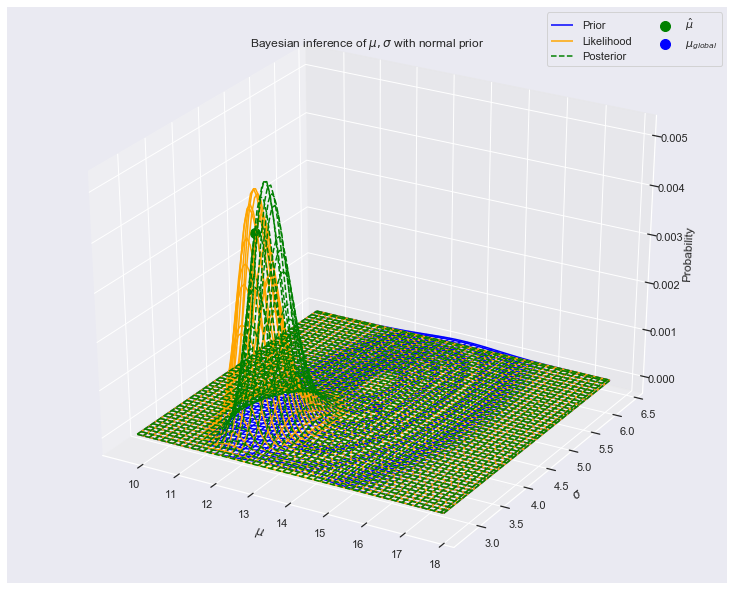

In [77]:
fig = plt.figure(figsize=((10,8)))
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, (pri_grid_norm/pri_grid_norm.sum()),  color='blue', label='Prior')
ax.plot_wireframe(X, Y, (lik_grid_norm/lik_grid_norm.sum()),  color='orange', label='Likelihood')
ax.plot_wireframe(X, Y, (post_grid_norm/post_grid_norm.sum()), color='green', linestyle='--', label='Posterior')

ax.scatter([μ_hat], [σ_hat], [np.exp(log_posterior_3d_norm((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_norm.sum()], s=100, color='green', label='$\hat{μ}$')
#ax.scatter([μ_pos], [σ_pos], [np.exp(log_posterior_3d_norm((μ_pos, σ_pos), one_pos_one_year_d))/post_grid_norm.sum()], s=100, color='blue', label='$μ_{'+pos.lower()+'}$')
ax.scatter([μ_global], [σ_global], [np.exp(log_posterior_3d_norm((μ_global, σ_global), one_pos_one_year_d))/post_grid_norm.sum()], s=100, color='blue', label='$μ_{global}$')

ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('Probability')
ax.set_title(f'Bayesian inference of $\mu,\sigma$ with normal prior')

ax.legend(ncol=2)

plt.show()

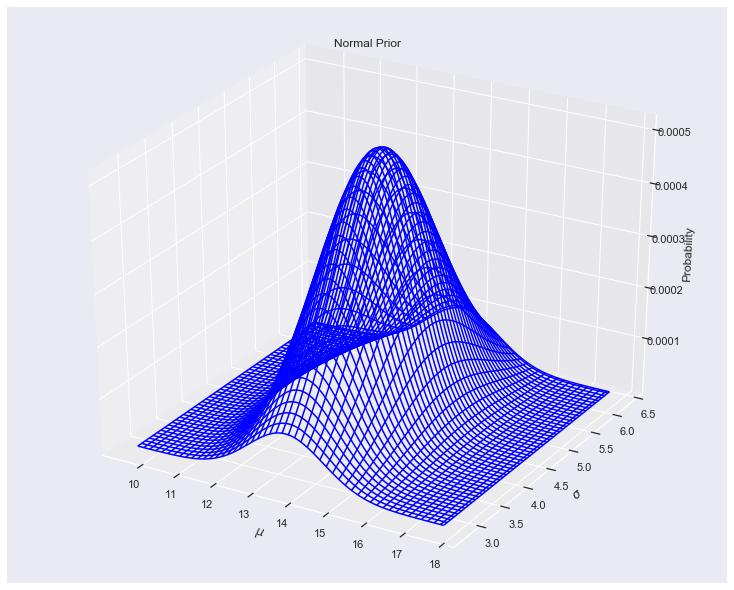

In [78]:
fig = plt.figure(figsize=((10,8)))
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, (pri_grid_norm/pri_grid_norm.sum()),  color='blue', label='Prior')

ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('Probability')
ax.set_title(f'Normal Prior')

plt.show()

In [79]:
print (f'μ_hat x σ_hat cordinates = ({μ_hat:.4f}, {σ_hat:.4f}, {np.exp(log_posterior_3d_norm((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_norm.sum():.6f})')
print (f'μ_pos x σ_pos coordinates = ({μ_pos:.4f}, {σ_pos:.4f}, {np.exp(log_posterior_3d_norm((μ_pos, σ_pos), one_pos_one_year_d))/post_grid_norm.sum():.6f})')
print (f'μ_global x σ_global coordinates = ({μ_global:.4f}, {σ_global:.4f}, {np.exp(log_posterior_3d_norm((μ_global, σ_global), one_pos_one_year_d))/post_grid_norm.sum():.8f})')



μ_hat x σ_hat cordinates = (11.8364, 3.4637, 0.004039)
μ_pos x σ_pos coordinates = (11.8315, 3.4933, 0.004119)
μ_global x σ_global coordinates = (13.6098, 4.5478, 0.00000016)


***
## MCMC 3d

In [80]:
ndim = 2
nwalkers = 50
nsteps  = 10000 // nwalkers
nburn = nsteps // 2

guesses = np.random.rand(nwalkers, ndim)
guesses[:, 0] *= 50  # start mu between 0 and 2000
guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_3d_norm, args=[one_pos_one_year_d])
sampler.run_mcmc(guesses, nsteps)

# sampler.chain.shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

In [81]:
μ_sample, σ_sample = sample[:,0], sample[:,1]
μ_hat, σ_hat = μ_sample.mean(), (σ_sample).mean()

In [82]:
μ_hat, σ_hat

(12.072887060443737, 3.60622040903779)

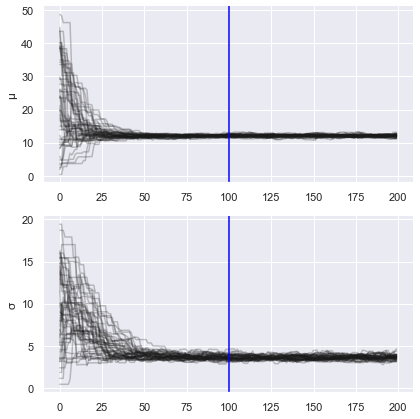

In [83]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6))

for i, varname in enumerate(['μ', 'σ']):
    ax = axes[i]
    ax.plot(sampler.chain[:,:,i].T, color='k', alpha=0.25);
    ax.axvline(nburn, color='blue')
    ax.set_ylabel(varname)

fig.tight_layout()
sns.despine()

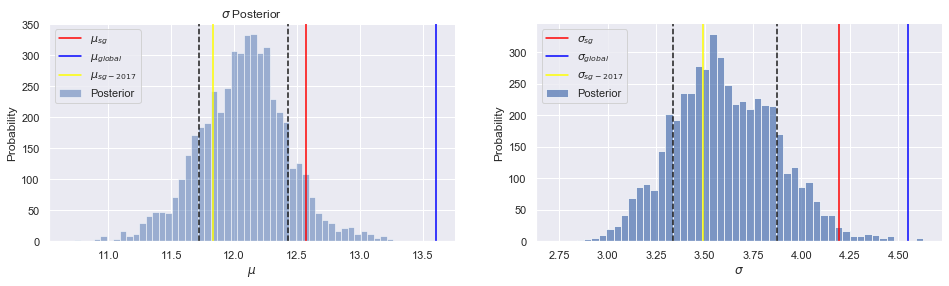

In [84]:
μ_pos_year, σ_pos_year = one_pos_one_year_d.mean(), one_pos_one_year_d.std()

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].hist(sample[:,0], bins=50, alpha=0.5, label='Posterior')
axes[0].axvline(μ_years_range[pos], color='red', label=r'$μ_{'+pos.lower()+'}$')
axes[0].axvline(μ_global, color='blue', label=r'$μ_{global}$')
axes[0].axvline(μ_pos_year, color='yellow', label='$μ_{'+pos.lower()+'-'+str(year)+'}$')
axes[0].axvline(μ_hat+sample[:,0].std(), color='k', ls='--')
axes[0].axvline(μ_hat-sample[:,0].std(), color='k', ls='--')
axes[0].set_xlabel("$\mu$")
axes[0].set_ylabel("Probability")
axes[0].set_title(r'$\mu$ Posterior')
axes[0].legend()

axes[1].hist(sample[:,1], bins=50, alpha=0.7, label='Posterior')
axes[1].axvline(σ_years_range[pos], color='red', label=r'$σ_{'+pos.lower()+'}$')
axes[1].axvline(σ_global, color='blue', label=r'$σ_{global}$')
axes[1].axvline(σ_pos_year, color='yellow', label='$σ_{'+pos.lower()+'-'+str(year)+'}$')
axes[1].axvline(σ_hat+sample[:,1].std(), color='k', ls='--')
axes[1].axvline(σ_hat-sample[:,1].std(), color='k', ls='--')
axes[1].set_xlabel("$\sigma$")
axes[1].set_ylabel("Probability")
axes[0].set_title(r'$\sigma$ Posterior')
axes[1].legend()


sns.despine()

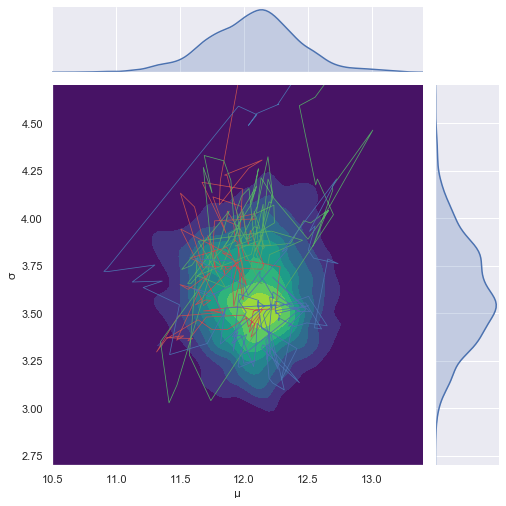

In [85]:
g = sns.jointplot(
    sampler.chain[:, nburn :, 0].ravel(), 
    sampler.chain[:, nburn:, 1].ravel(), 
    kind='kde', cmap='viridis', height=7, 
    xlim=(10.5, 13.4), ylim=(2.7,4.7))
g.set_axis_labels('μ', 'σ')

for i, c in enumerate('rgb'):
    g.ax_joint.plot(sampler.chain[i, :, 0], sampler.chain[i, :, 1], lw=0.75, color=c)
    

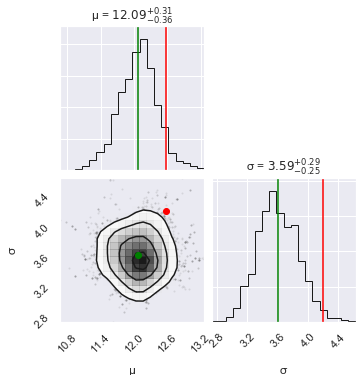

In [86]:
cor = corner(sample, 
    smooth=True,
    labels=['μ', 'σ'],
    show_titles=True,
)
cor.axes[0].axvline(μ_years_range[pos], color='red', label=r'$μ_{'+pos.lower()+'}$')
cor.axes[3].axvline(σ_years_range[pos], color='red', label=r'$μ_{'+pos.lower()+'}$')
cor.axes[2].plot(μ_years_range[pos], σ_years_range[pos], 'o', color='red', label=r'$μ_{'+pos.lower()+'}$')

# cor.axes[0].axvline(μ_global, color='blue')
# cor.axes[3].axvline(σ_global, color='blue')
# cor.axes[2].plot(μ_global, σ_global, 'o', color='blue')

cor.axes[0].axvline(μ_hat, color='green')
cor.axes[3].axvline(σ_hat, color='green')
cor.axes[2].plot(μ_hat, σ_hat, 'o', color='green')

plt.show()

***
### Scipy optimization using fmin

In [87]:
def neg_log_likelihood(θ, X):
    return -log_likelihood(θ, X)

θ_hat, θ_path =scipy.optimize.fmin(
    func=neg_log_likelihood, 
    x0=(μ_global*1.4, σ_global*0.60), 
    args=(one_pos_one_year_d,),
    retall=1
)
θ_path = np.array(θ_path)
θ_hat

Optimization terminated successfully.
         Current function value: 237.107039
         Iterations: 38
         Function evaluations: 73


array([11.8314959 ,  3.47359363])

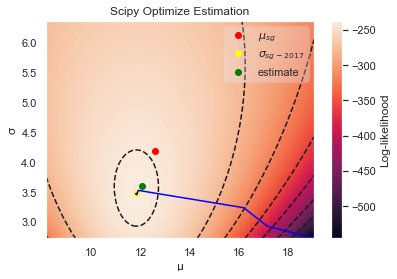

In [88]:
μ_range = np.linspace(μ_global*0.60, μ_global*1.4, 100)
σ_range = np.linspace(σ_global*0.60, σ_global*1.4, 100)
ll = np.array([
    [log_likelihood((μ_, σ_), one_pos_one_year_d) for μ_ in μ_range]
    for σ_ in σ_range
])

im = plt.pcolormesh(μ_range, σ_range, ll)
plt.contour(μ_range, σ_range, ll, colors='k')
plt.colorbar(im, label='Log-likelihood')
plt.plot(μ_years_range[pos], σ_years_range[pos], 'o', color='red', label=r'$μ_{'+pos.lower()+'}$')
plt.plot(μ_pos_year, σ_pos_year, 'o', color='yellow', label='$σ_{'+pos.lower()+'-'+str(year)+'}$')
plt.plot(μ_hat, σ_hat, 'o', color='green', label='estimate')
plt.plot(θ_path[:,0], θ_path[:,1], '-', color='blue')
plt.xlabel('μ')
plt.ylabel('σ')
plt.legend(framealpha=0.3)
plt.title ('Scipy Optimize Estimation')
plt.show()

***
### ABC

ABC (Approximate Bayesian Computation) is a likelihood free approach that uses simulations to approximate the posterior. 

Together with Monte Carlo approach that we used before (MCMC), we wil use the Sequential Monte Carlo sampler (ABC SMC).

This method is generating samples ("particles"), and performs a series of steps similar to MCMC to move them around the parameter space.

This step creates a new population that will now move to the next itteration.

The algorithm will stop once it reaches to distance below the $\epsilon$ or number of maximum population has been reached (N).

For distance function we used the ABS distance.

In [89]:
import pyabc

In [90]:
N = 2000 # Experiments
n = 100 # Samples per experiment
ϵ = 0.5 # Acceptance rate: ρ* <= ϵ
μ_year_pos = one_pos_one_year_d.mean()
σ_year_pos = one_pos_one_year_d.std()

We will use the same priors:

$\mu$ ~ $N(\mu_{global},1)$

$\sigma$ ~ $N(\sigma_{global}, 1)$

In [91]:
priors = pyabc.Distribution(
    μ = pyabc.RV("norm", μ_global, 1),
    σ = pyabc.RV("norm", σ_global, 1)
)
priors.rvs()

<Parameter 'μ': 13.347496670835799, 'σ': 5.672485594666774>

In [93]:
 def model(parameters):
    X = simulator(parameters['μ'], parameters['σ'], n=n)
    S1, S2 = summary(X).squeeze()
    return dict(
        S1=S1,
        S2=S2
    )

model(priors.rvs())

{'S1': 13.58, 'S2': 6.73327332706535}

In [94]:
def simulator(μ, σ, n=1):
    """μ, σ: parameters
       n: number of samples
    """
    μ, σ = np.atleast_1d(μ, σ)
    F = scipy.stats.norm(μ, σ).rvs(size=(n, μ.size))
    X_sim = scipy.stats.poisson(np.maximum(F, 0)).rvs()
    return X_sim.T

def summary(X):
    X = np.atleast_2d(X)
    S1 = X.mean(axis=1)
    S2 = X.std(axis=1, ddof=1)
    return np.array([S1, S2])

def distance(simulation, data):
    return (
        np.abs(data['S1'] - simulation['S1']) +
        np.abs(data['S2'] - simulation['S2'])
    )[0]

observation = dict(S1=np.array([μ_year_pos]), S2=np.array([σ_year_pos]))

distance(model(priors.rvs()), observation)

4.220563509525312

In [95]:
abc = pyabc.ABCSMC(
    model, 
    priors, 
    distance,
    population_size=N, 
    # you can try to remove the next line and see if multicore sampler (the default) works
    sampler=pyabc.SingleCoreSampler()
)

In [96]:
db_path = "sqlite:///pyabc_nba.db"

In [97]:
abc.new(db_path, observation)

INFO:History:Start <ABCSMC(id=1, start_time=2020-08-29 20:30:41.026049, end_time=None)>


In [98]:
history = abc.run(minimum_epsilon=ϵ)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 4.176576955074854
INFO:ABC:t: 0, eps: 4.176576955074854.
INFO:ABC:Acceptance rate: 2000 / 3914 = 5.1099e-01, ESS=2.0000e+03.
INFO:ABC:t: 1, eps: 3.1442259783697004.
INFO:ABC:Acceptance rate: 2000 / 4580 = 4.3668e-01, ESS=1.8294e+03.
INFO:ABC:t: 2, eps: 2.514015683797865.
INFO:ABC:Acceptance rate: 2000 / 5282 = 3.7864e-01, ESS=1.3998e+03.
INFO:ABC:t: 3, eps: 2.0528960468947135.
INFO:ABC:Acceptance rate: 2000 / 6437 = 3.1070e-01, ESS=1.0047e+03.
INFO:ABC:t: 4, eps: 1.6948996602942203.
INFO:ABC:Acceptance rate: 2000 / 6890 = 2.9028e-01, ESS=5.4651e+02.
INFO:ABC:t: 5, eps: 1.4055133004620388.
INFO:ABC:Acceptance rate: 2000 / 8303 = 2.4088e-01, ESS=1.1406e+03.
INFO:ABC:t: 6, eps: 1.1449600600153789.
INFO:ABC:Acceptance rate: 2000 / 9399 = 2.1279e-01, ESS=8.0510e+02.
INFO:ABC:t: 7, eps: 0.9241864463800298.
INFO:ABC:Acceptance rate: 2000 / 11424 = 1.7507e-01, ESS=5.3662e+02.
INFO:ABC:t: 8, eps: 0.7356489069895688.
INFO:AB

ValueError: Domain error in arguments.

In [ ]:
abc.load(db_path, history.id) # load from file
history = abc.history

history.total_nr_simulations

In [ ]:
samples, weights = history.get_distribution(m=0)
μ_sample, σ_sample = samples['μ'], samples['σ']
μ_hat, σ_hat = np.average(μ_sample, weights=weights), np.average(σ_sample, weights=weights)

print("μ_pos_year = {} \tμ_hat = {:.2f}\nσ_pos_year = {}\t\tσ_hat = {:.2f}".format(
    μ_year_pos, μ_hat, σ_year_pos, σ_hat))

In [ ]:
fig, axes = plt.subplots(history.max_t//4+1, 4, figsize=(18, 8), sharex=True, sharey=True)
for t in range(history.max_t + 1):
    ax = axes.flat[t]
    samples_, weights_ = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_2d(
        samples_, weights_, "μ", "σ",
        xmin=10, xmax=15, ymin=1, ymax=6, colorbar=False, ax=ax)
    ax.plot(μ_year_pos, σ_year_pos, '*', color='yellow')
    ax.plot(μ_hat, σ_hat, '*', color='green')
    ax.set_title("Posterior t={}".format(t))
fig.tight_layout()

In [ ]:
def plot_history(history):
    fig, axes = plt.subplots(1,2,  figsize=(18, 4))
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=9, xmax=17,
                                       x='μ', ax=axes[0],
                                       label="PDF t={}".format(t))
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=6,
                                       x='σ', ax=axes[1],
                                       label="PDF t={}".format(t))
    axes[0].axvline(μ_year_pos, color='k', linestyle='dashed', label='$μ_{'+pos.lower()+'-'+str(year)+'}$')
    axes[1].axvline(σ_year_pos, color='k', linestyle='dashed', label='$σ_{'+pos.lower()+'-'+str(year)+'}$')
    axes[0].legend()
    axes[1].legend()
    axes[0].set_title('μ')
    axes[1].set_title('σ')

In [ ]:
plot_history(history)

In [ ]:
cor = corner(samples, 
    weights=weights,
    title_fmt='.3f', 
    smooth=True,
    show_titles=True,
    truths=(one_pos_one_year_d.mean(), μ_hat, one_pos_one_year_d.std()),
    truth_color='red'
)
cor.axes[0].axvline(μ_hat, color='blue')
cor.axes[3].axvline(σ_hat, color='blue')
cor.axes[2].axvline(μ_hat, color='blue')
cor.axes[2].axhline(σ_hat, color='blue')
plt.show()

We can see that for the $\mu$ value the ABC MSC converges from the initial mean to toward the data value ($μ_{sg\_2017}$) while the $\sigma$ seems to take diffrent direction.
***
***

## Model Evalution of Positional-PER using Bayesian Inference Single Parameter Estimation (Normal prior)


We've selected to evalute the pPER using the Bayesian Inference Single Parameter with Normal prior.

Let's infer the $\Theta = (\hat{\mu},\hat{\sigma}=\sigma_{global}) $ parameters for each position and evalute the pPER with regards to the infered parameters.

In [155]:
print('We will use μ_global = {:.2f}, σ_global = {:.2f}'.format(μ_global, σ_global))
print("Let's evalute the {} season".format(year))

We will use μ_global = 13.61, σ_global = 4.55
Let's evalute the 2017 season


In [156]:

for pp in unique_pos:
    pp = 'SG'
    df_1year_1pos = dbb.loc[(dbb['Year']==year) & (dbb['Pos']==pp),'PER']
    Bayes1Norm = BayesSingleParameterNormal(df_1year_1pos, μ_global, σ_global, pp, year)
    
    Bayes1Norm_μ_hat = Bayes1Norm.estimate_model_params()
    add_pPER_2_db(dbb, year, pp, μ=Bayes1Norm_μ_hat, σ=σ_global)
#     Bayes1Norm.plot_results()



In [164]:

def find_candidates_df(df):
    mvp_winner = df.loc[df['MVP'],['Player','PER','pPER']].squeeze().to_dict()
    mvp_winner['Award'] = 'MVP Winner'
    max_per = get_max_stat(df, 'PER').to_dict()
    max_per['Award'] = 'Max PER'
    max_pper = get_max_stat(df, 'pPER').to_dict()
    max_pper['Award'] = 'Max pPER'
    df_Candidates = pd.DataFrame([mvp_winner, max_per, max_pper])
    columns_titles = ['Award', 'Player','PER', 'pPER']
    df_Candidates = df_Candidates.reindex(columns=columns_titles)
    return df_Candidates
        
def analyse_mvp_award(db, years=[], verbose=True):
    if not years:
        years = np.unique(db['Year'])
    for year in years:
        print (f"\033[4mYear: {year}\033[0m")
        db_sliced = db[db['Year'] == year]
        df_Candidates = find_candidates_df(db_sliced)
        if verbose:
            if df_Candidates['Player'][0] != df_Candidates['Player'][1]: # MVP doesn't match MaxPER
                ccolor = 'red'
                print(colored("MVP doesn't match Max PER", ccolor))
            elif df_Candidates['Player'][1] != df_Candidates['Player'][2]: # MaxPER doesn't match MaxaPER
                ccolor = 'magenta'
                print(colored("Max PER doesn't match Max pPER", ccolor))
            else:
                ccolor = 'grey'
                print(colored("All figure of merit match!", ccolor))
            print(colored(df_Candidates, ccolor))
            print("="*55)
            

#### Single year (2017) evalution

In [160]:
analyse_mvp_award(dbb, [2017])

Year: 2017
Max PER doesn't match Max pPER
        Award             Player   PER  pPER
0  MVP Winner  Russell Westbrook  30.6  3.08
1     Max PER  Russell Westbrook  30.6  3.08
2    Max pPER       Kevin Durant  27.6  3.38


We can see that although Russel Westbrook won the MVP award, perhaps it should have gone to DeMar DeRozan, as he was the most dominant player with respect to his position on the floor.

Let's see if this occurs in other years as well

#### Comparison of MVP vs. aMVP 

In [165]:
analyse_mvp_award(dbb)


Year: 2013
Max PER doesn't match Max pPER
        Award        Player   PER  pPER
0  MVP Winner  LeBron James  31.6  3.86
1     Max PER  LeBron James  31.6  3.86
2    Max pPER  Kevin Durant  28.3  4.46
Year: 2014
All figure of merit match!
        Award        Player   PER  pPER
0  MVP Winner  Kevin Durant  29.8  4.46
1     Max PER  Kevin Durant  29.8  4.46
2    Max pPER  Kevin Durant  29.8  4.46
Year: 2015
MVP doesn't match Max PER
        Award         Player   PER  pPER
0  MVP Winner  Stephen Curry  28.0  3.11
1     Max PER  Anthony Davis  30.8  3.81
2    Max pPER  Anthony Davis  30.8  3.81
Year: 2016
All figure of merit match!
        Award         Player   PER  pPER
0  MVP Winner  Stephen Curry  31.5  3.73
1     Max PER  Stephen Curry  31.5  3.73
2    Max pPER  Stephen Curry  31.5  3.73
Year: 2017
Max PER doesn't match Max pPER
        Award             Player   PER  pPER
0  MVP Winner  Russell Westbrook  30.6  3.08
1     Max PER  Russell Westbrook  30.6  3.08
2    Max pPER       

***
***
### Conclusions

The pPER figure of merit shows a dominance of a player with regards to his position on the floor, compared to fellow players on the same position.

This figure of merit, we believe, indicates best the player which shall be elected to be the Most Valuable Player.

In addition, the pPER can help college scouts to select draftees in the upcoming NBA draft as most teams seek a specific position in a given year. For example, in 1984 the Huston Rockets selected first Hakeem Olajuwon as they needed a Center (the best player from this draft is of course the SG Michael Jordan)

# Appendix

# Playground to delete:

In [ ]:
# def log_prior_uni(θ):
#     μ, σ = θ
#     if μ > 0 and σ > 0:
#         return 0
#     else:
#         return -np.inf
    
# def log_posterior_uni(θ, X):
#     pri = log_prior_uni(θ)
#     if np.isinf(pri): 
#         return pri
#     return pri + log_likelihood(θ, X)

In [ ]:
#TODO: Do 3D MLE
# μ = μ_years_range[pos]
# σ = σ_years_range[pos]
# μ_MLE = one_pos_one_year_d.mean()
# σ_MLE = one_pos_one_year_d.std()
# print("μ = {:.2f} \nμ_MLE = {:.2f}".format(μ, μ_MLE))
# print("σ = {:.2f} \nσ_MLE = {:.2f}".format(σ, σ_MLE))

In [ ]:
# def plot_pri_post_like(X, μ, σ, log_prior, log_likelihood, log_posterior):
# #     μ_hat = X.mean()
# #     σ_hat = X.std()
#     μ_range = np.linspace(μ*0.70, μ*1.3, 400)
#     pri = np.exp([log_prior(μ_) for μ_ in μ_range])
#     lik = np.exp([log_likelihood(μ_, σ, X) for μ_ in μ_range])
#     post = np.exp([log_posterior(μ_, σ, X) for μ_ in μ_range])
#     μ_hat = μ_range[post.argmax()] # maximum a posterioi estimate
#     print("μ = {} \nμ_hat = {:.2f}".format(μ, μ_hat))
#     plt.plot(μ_range, pri/pri.sum(), label='prior')
#     plt.plot(μ_range, lik/lik.sum(), lw=3, label='likelihood')
#     plt.plot(μ_range, post/post.sum(), ls='--', label='posterior')
#     plt.plot(μ, np.exp(log_posterior(μ, σ, X))/post.sum(), 'o', color='red', label='$μ$')
#     plt.plot(μ_hat, np.exp(log_posterior(μ_hat, σ_hat, X))/post.sum(), 'o', color='green', label='$\hat{μ}$')

#     plt.xlabel("PER")
#     plt.ylabel("Probability")
#     plt.yscale("log")
#     plt.legend(ncol=2)
#     sns.despine()

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# μ_range = np.linspace(μ*0.70, μ*1.3, 100)
# σ_range = np.linspace(σ*0.80, σ*1.2, 100)

# X, Y = np.meshgrid(μ_range, σ_range)

In [ ]:
# Create grid and calc prior, likelihood and posterior for each
# μ_range = np.linspace(μ*0.8, μ*1.2, 100)
# σ_range = np.linspace(σ*0.7, σ*1.3, 100)

# X, Y = np.meshgrid(μ_range, σ_range)

# pri_grid_uni = np.empty([len(μ_range), len(σ_range)])
# lik_grid_uni = np.empty([len(μ_range), len(σ_range)])
# post_grid_uni = np.empty([len(μ_range), len(σ_range)])

# for μi, μ_ in enumerate(μ_range):
#     for σi, σ_ in enumerate(σ_range):
#         pri_grid_uni[σi][μi] = np.exp(log_prior_uni((μ_, σ_)))
#         lik_grid_uni[σi][μi] = np.exp(log_likelihood((μ_, σ_), one_pos_one_year_d))
#         post_grid_uni[σi][μi] = np.exp(log_posterior_uni((μ_, σ_), one_pos_one_year_d))




In [ ]:
# %matplotlib notebook

In [ ]:
# print (f'μ x σ cordinates = ({μ:.2f}, {σ:.2f}, {np.exp(log_posterior_uni((μ, σ), one_pos_one_year_d))/post_grid_uni.sum():.5f})')

# σ_hat_idx, μ_hat_idx = np.unravel_index(post_grid_uni.argmax(), post_grid_uni.shape)
# μ_hat, σ_hat = μ_range[μ_hat_idx], σ_range[σ_hat_idx]
# print (f'μ_hat x σ_hat cordinates = ({μ_hat:.2f}, {σ_hat:.2f}, {np.exp(log_posterior_uni((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_uni.sum():.7f})')




In [ ]:
# ppp = post_grid_uni.max()/post_grid_uni.sum()
# ppp

In [ ]:
# fig = plt.figure(figsize=((10,8)))
# ax = Axes3D(fig)
# ax.plot_wireframe(X, Y, (lik_grid_uni/lik_grid_uni.sum()),  color='orange', label='Likelihood')
# ax.plot_wireframe(X, Y, (post_grid_uni/post_grid_uni.sum()), color='green', linestyle='--', label='Posterior')

# ax.scatter([μ_hat], [σ_hat], [np.exp(log_posterior_uni((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_uni.sum()], s=100, color='black', label='$\hat{μ}$')
# ax.scatter([μ], [σ], [np.exp(log_posterior_uni((μ, σ), one_pos_one_year_d))/post_grid_uni.sum()], color='red', s=100, label='$μ$')

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# # ax.zaxis._set_scale('log')
# # ax.yaxis.set_scale('log').yaxis.set_scale('log')
# # ax.zaxis._set_scale('log')
# plt.show()


Assuming independent $\sigma$ and $\mu$

In [ ]:

# log_pr = scipy.stats.norm(14, 4).logpdf(11.83) + scipy.stats.norm(4, 1).logpdf(3.5)




In [ ]:
# TODO: Try and add covariance compensation
# def log_prior_norm(θ):
#     μ, σ = θ
#     if μ > 0 and σ > 0:
#         return scipy.stats.norm(14, 4).logpdf(μ) + scipy.stats.norm(4, 1).logpdf(σ)
#     else:
#         return -np.inf

In [ ]:
# def log_posterior_norm(θ, X):
#     pri = log_prior_norm(θ)
#     if np.isinf(pri): 
#         return pri
#     return pri + log_likelihood(θ, X)

In [ ]:
# Create grid and calc prior, likelihood and posterior for each
# μ_range = np.linspace(μ*0.8, μ*1.2, 100)
# σ_range = np.linspace(σ*0.7, σ*1.3, 100)

# X, Y = np.meshgrid(μ_range, σ_range)

# pri_grid_norm = np.empty([len(μ_range), len(σ_range)])
# lik_grid_norm = np.empty([len(μ_range), len(σ_range)])
# post_grid_norm = np.empty([len(μ_range), len(σ_range)])

# #TODO: make this function more efficient
# for μi, μ_ in enumerate(μ_range):
#     for σi, σ_ in enumerate(σ_range):
#         pri_grid_norm[σi][μi] = np.exp(log_prior_norm((μ_, σ_)))
#         lik_grid_norm[σi][μi] = np.exp(log_likelihood((μ_, σ_), one_pos_one_year_d))
#         post_grid_norm[σi][μi] = np.exp(log_posterior_norm((μ_, σ_), one_pos_one_year_d))

In [ ]:
# print (f'μ x σ cordinates = ({μ:.2f}, {σ:.2f}, {np.exp(log_posterior_norm((μ, σ), one_pos_one_year_d))/post_grid_norm.sum():.5f})')

# σ_hat_idx, μ_hat_idx = np.unravel_index(post_grid_norm.argmax(), post_grid_norm.shape)
# μ_hat, σ_hat = μ_range[μ_hat_idx], σ_range[σ_hat_idx]
# print (f'μ_hat x σ_hat cordinates = ({μ_hat:.2f}, {σ_hat:.2f}, {np.exp(log_posterior_norm((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_norm.sum():.7f})')




In [ ]:
#TODO: Plot one plot with only prior

print (f'μ_hat x σ_hat cordinates = ({μ_hat:.2f}, {σ_hat:.2f}, {np.exp(log_posterior_uni((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_uni.sum():.5f})')
print (f'μ x σ cordinates = ({μ:.2f}, {σ:.2f}, {np.exp(log_posterior_uni((μ, σ), one_pos_one_year_d))/post_grid_uni.sum():.5f})')
# print (f'Max likelihood = {max(np.exp(log_posterior_norm((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_norm.sum())}')

fig = plt.figure(figsize=((10,8)))
ax = Axes3D(fig)

ax.plot_wireframe(X, Y, (lik_grid_norm/lik_grid_norm.sum()),  lw=3, color='orange')
ax.plot_wireframe(X, Y, (post_grid_norm/post_grid_norm.sum()), color='green', linestyle='--')
ax.plot_wireframe(X, Y, (pri_grid_norm/pri_grid_norm.sum()),  color='purple')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.scatter([μ_hat], [σ_hat], [np.exp(log_posterior_norm((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_norm.sum()], s=1000, color='black', label='$\hat{μ}$')
ax.scatter([μ], [σ], [np.exp(log_posterior_norm((μ, σ), one_pos_one_year_d))/post_grid_norm.sum()], color='red', s=1000)
# ax.scatter(m[i,0],m[i,1],m[i,2],color='b') 
# ax.scatter([μ_hat], [σ_hat], [np.exp(log_posterior_uni((μ_hat, σ_hat), one_pos_one_year_d))/post_grid.sum()], s=1000, color='red')
# ax.scatter([μ], [σ], [np.exp(log_posterior_uni((μ, σ), one_pos_one_year_d))/post_grid.sum()], color='black', s=1000)
# ax.zaxis._set_scale('log')
# ax.yaxis.set_scale('log').yaxis.set_scale('log')
plt.show()

In [ ]:
np.exp(log_posterior_norm((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_norm.sum()

In [ ]:
log_posterior_norm((μ_hat, σ_hat), one_pos_one_year_d)

In [ ]:
np.unravel_index(b.argmax(), b.shape)

In [ ]:
μ_range[35], σ_range[23]

In [ ]:
X[23][40], Y[23][40]

In [ ]:
a=lik_grid_norm/lik_grid_norm.sum()

In [ ]:
a.max()

In [ ]:
np.unravel_index(a.argmax(), a.shape)

Now we will change the prior to Norm

In [ ]:
def plot_pri_post_like(X, μ, σ, log_prior, log_likelihood, log_posterior):
#     μ_hat = X.mean()
#     σ_hat = X.std()
    μ_range = np.linspace(μ*0.70, μ*1.3, 400)
    pri = np.exp([log_prior((μ_, σ)) for μ_ in μ_range])
    lik = np.exp([log_likelihood((μ_, σ), X) for μ_ in μ_range])
    post = np.exp([log_posterior((μ_, σ), X) for μ_ in μ_range])
    μ_hat = μ_range[post.argmax()] # maximum a posterioi estimate
    
    plt.plot(μ_range, pri/pri.sum(), label='prior')
    plt.plot(μ_range, lik/lik.sum(), lw=3, label='likelihood')
    plt.plot(μ_range, post/post.sum(), ls='--', label='posterior')
    plt.plot(μ, np.exp(log_posterior((μ, σ), X))/post.sum(), 'o', color='red', label='$μ$')
    #plt.plot(μ_hat, np.exp(log_posterior((μ_hat, σ_hat), X))/post.sum(), 'o', color='green', label='$\hat{μ}$')
    plt.plot(μ_hat, np.exp(log_posterior((μ_hat, σ), X))/post.sum(), 'o', color='green', label='$\hat{μ}$')

    plt.xlabel("PER")
    plt.ylabel("Probability")
#     plt.yscale("log")
    plt.legend(ncol=2)
    sns.despine()

In [ ]:
# def log_prior_norm(θ):
#     μ, σ = θ
#     if μ > 0 and σ > 0:
#         return scipy.stats.norm(11.8, 3.5).logpdf(μ)
#     else:
#         return -np.inf
    
# def log_posterior_norm(θ, X):
#     pri = log_prior_norm(θ)
#     if np.isinf(pri): 
#         return pri
#     return pri + log_likelihood(θ, X)

In [ ]:
# def log_posterior_norm(θ, X):
#     pri = log_prior_norm(θ)
#     if np.isinf(pri): 
#         return pri
#     return pri + log_likelihood(θ, X)

In [ ]:
print(f'μ={μ:.2f}, σ={σ:.2f}')
print(f'μ_hat={μ_hat:.2f}, σ_hat={σ_hat:.2f}') 

In [ ]:
plot_pri_post_like(one_pos_one_year_d, μ, σ, log_prior_norm, log_likelihood, log_posterior_norm)
#TODO: plot also Uniform
#TODO: Take all this up

## Create a model for estimating the PER mean/std for prior

OK. So if we want to extract the best player with regards to his position, we need to be able to find the best fit for the distribution of each position.

We will use few methods:

- Baysian Inference
- ABC 
- ...

The goal will be to compute the model parameters $\Theta=(\mu , \sigma)$ for each position.

We want to use the PER mean and STD as prior.

Let's first look at the PER over the last 15 years

In [ ]:
columns_to_convert = ['Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%',
                    'TOV%','USG%','OWS' ,'DWS','WS','WS/48','OBPM','DBPM','BPM','VORP']
mean_per = []
std_per = []
for y in range(*years_range,1):
    url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'.format(y)
    df=fetch_data(url)
    preprocess_df(columns_to_convert)
    mean_per.append(np.mean(df['PER']))
    std_per.append(np.std(df['PER']))

In [ ]:
mean_per

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].plot(range(*years_range), mean_per, 'o')
axes[1].plot(range(*years_range), std_per, 'x')
sns.despine()


In [ ]:
from scipy.optimize import curve_fit

In [ ]:
def lin_func(x,a,b):
    return a*x+b

In [ ]:
pars, cov = curve_fit(f=lin_func, xdata=range(*years_range,1), ydata=mean_per)

In [ ]:
pars

In [ ]:
cov

In [ ]:
plt.plot(range(*years_range), lin_func(range(*years_range,1), pars[0], pars[1]))
plt.plot(range(*years_range), mean_per, 'x', color='orange')
plt.show()
#TODO: Add variance to the line. Maybe sample from the normal dist of a,b

In [ ]:
def get_per(func, year, params):
    return func(year, *params)

In [ ]:
get_per_mean_and_var(lin_func, 2016, pars)

In [ ]:
import statsmodels.api as sm

In [ ]:
y = mean_per
X = sm.add_constant(range(*years_range)) # for intercept
results = sm.OLS(y, X).fit()
print(results.summary())

# Baysian Inference for PER line

In [ ]:
a_prior = scipy.stats.norm(5, 0.2)
b_prior = scipy.stats.norm(-9, 0.1)
σ_prior = scipy.stats.expon(0.1)

def log_prior(θ):
    a, b, σ = θ
    return a_prior.logpdf(a) + b_prior.logpdf(b) + σ_prior.logpdf(σ)

def log_likelihood(θ, x, y):
    a, b, σ = θ
    yhat = a * x + b
    return scipy.stats.norm(yhat, σ).logpdf(y).sum()

def log_posterior(θ, x, y):
    logpri = log_prior(θ)
    if np.isinf(logpri): return logpri
    return logpri + log_likelihood(θ, x, y)

In [ ]:
ndim = 3
nwalkers = 50
nsteps  = 200
nburn = nsteps // 2
var_names = ['a', 'b', 'σ']

guesses = np.random.rand(nwalkers, ndim)
guesses[:, 0] = a_prior.rvs(nwalkers)
guesses[:, 1] = b_prior.rvs(nwalkers)
guesses[:, 2] = σ_prior.rvs(nwalkers)

In [ ]:
x = range(*years_range,1)
y = mean_per

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y])
sampler.run_mcmc(guesses, nsteps);

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, param in enumerate(['a', 'b', 'σ']):
    axes[i].plot(sampler.chain[:, nburn:, i])
    axes[i].set_ylabel(param)
fig.tight_layout()

In [ ]:
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
θ_bayes = samples.mean(axis=0)
# print("Normal: a={:.3f}, b={:.3f}".format(*θ_norm))
print("Bayes:  a={:.3f}, b={:.3f}, σ={:.3f}".format(*θ_bayes))

In [ ]:
#plt.plot(lin_func(range(*years_range,1), pars[0], pars[1]))

for θi in samples:
    ai, bi, _ = θi
    yhat = ai * x + bi
    plt.plot(x, yhat, '-k', alpha=0.01)
    
a, b, σ = θ_bayes
yhat = a * x + b
plt.plot(x, yhat, color='red')
# comment out the next lines to get a predictive interval around the linear estimate
# plt.plot(x, yhat+σ, color=red)
# plt.plot(x, yhat-σ, color=red)

plt.plot(range(*years_range,1), mean_per, 'x', color='orange')
plt.ylim(5,25)

plt.xlabel('Years')
plt.ylabel('Mean PER')
sns.despine()

In [ ]:
#TODO: Try to fit diffrent lines

In [ ]:
from corner import corner

In [ ]:
corner(
    samples, 
    smooth=True, 
    labels=var_names, 
    show_titles=True, 
    truths=θ_bayes, 
    truth_color="green"
);